In [93]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects
from matplotlib import rcParams
from highlight_text import ax_text, fig_text
import pandas as pd

from PIL import Image
import urllib
import os

In [94]:
df = pd.read_csv("data/brier_score.csv",encoding="utf-8")
df["date"] = pd.to_datetime(df["date"])

In [95]:
df["home_win"] = [1 if x > y else 0 for x,
                  y in zip(df["score_home"], df["score_away"])]
df["tie"] = [1 if x == y else 0 for x, y in zip(
    df["score_home"], df["score_away"])]
df["away_win"] = [1 if x < y else 0 for x,
                  y in zip(df["score_home"], df["score_away"])]
df = df.assign(
    brier_score=lambda x: 1/3 *
    ((x.prob_home-x.home_win)**2 +
     (x.prob_tie-x.tie)**2 +
     (x.prob_away-x.away_win)**2)
)

In [96]:
teams = df[["home_team_id"]].drop_duplicates()

plot_df = pd.DataFrame()

for team in teams["home_team_id"]:
    aux_df = df[(df["home_team_id"] == team) | (df["away_team_id"] == team)].copy()

    cum_mean = (aux_df["brier_score"].expanding().mean())

    new_df = pd.DataFrame()
    new_df["cum_mean"] = cum_mean
    new_df["team_id"] = team

    plot_df = plot_df.append(new_df)

plot_df = pd.merge(
    plot_df,
    df[["home_team_id", "home_team_name"]].drop_duplicates(),
    how="left",
    left_on="team_id",
    right_on="home_team_id"
).rename(columns={"home_team_name": "team_name"})

team_colors = pd.read_csv("data/team_colors.csv")
plot_df = pd.merge(plot_df, team_colors, how="left")


C:\Users\argon\AppData\Local\Temp\ipykernel_15644\3506310154.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(new_df)
C:\Users\argon\AppData\Local\Temp\ipykernel_15644\3506310154.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(new_df)
C:\Users\argon\AppData\Local\Temp\ipykernel_15644\3506310154.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(new_df)
C:\Users\argon\AppData\Local\Temp\ipykernel_15644\3506310154.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(new_df)
C:\Users\argon\AppData\Local\Temp\ipykernel_15644\350631

In [97]:
def plot_team_brier_score(ax, team_id, data, label_y=True, label_x=True):
    df = data.copy()

    team_df = df[df["team_id"] == team_id].reset_index(drop = True)
    color = team_df["color"].iloc[0]

    ax.plot(
        team_df.index,
        team_df["cum_mean"],
        color = color,
        lw = 1.75,
        zorder = 3,
        marker = "o",
        markevery = [-1],
        markeredgecolor = "#EFE9E6"
    )

    ax.annotate(
        xy = (team_df.index[-1], team_df["cum_mean"].iloc[-1]),
        xytext = (15, 0),
        text = f'{team_df["cum_mean"].iloc[-1]:.3f}',
        textcoords = "offset points",
        ha = "center",
        va = "center",
        color = color,
        weight = "bold",
        size = 8
    )

    for x in df["team_id"].unique():
        if x == team_id:
            continue
        aux_df = df[df["team_id"] == x].reset_index(drop = True)

        ax.plot(
            aux_df.index,
            aux_df["cum_mean"],
            color = "gray",
            alpha = 0.15,
            lw = 1.25,
            zorder = 2
        )

    ax.grid(ls = ":", color = "lightgrey")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

    if label_y:
        ax.set_ylabel("Brier score")
    else:
        ax.set_yticklabels([])
    if label_x:
        ax.set_xlabel("Match day")
    else:
        ax.set_xticklabels([])

    return ax


In [98]:
order_teams = (
    plot_df.groupby(["team_id"])
    ["cum_mean"]
    .last()
    .reset_index()
    .sort_values(by = "cum_mean")
)

fig = plt.figure(figsize=(9,7),dpi=200)
nrows = 10
ncols = 4
gspec = gridspec.GridSpec(
    ncols=ncols,nrows=nrows,figure=fig,
    height_ratios=[(1/nrows)*2.35 if x%2!=0 else (1/nrows)/2.35 for x in range(nrows)], hspace=.2
)

<Figure size 1800x1400 with 0 Axes>

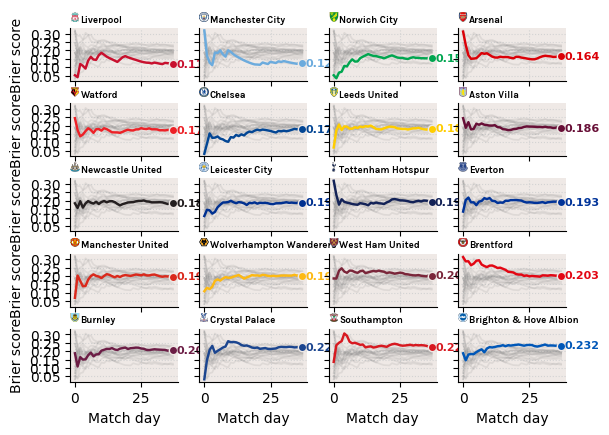

In [99]:
plot_counter = 0
logo_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(gspec[row, col], facecolor="#EFE9E6")

            teamId = order_teams["team_id"].iloc[plot_counter]

            if col == 0:
                labels_y = True
            else:
                labels_y = False

            if row == nrows - 1:
                labels_x = True
            else:
                labels_x = False

            plot_team_brier_score(ax, teamId, plot_df, labels_y, labels_x)

            plot_counter += 1
        else:
            teamId = order_teams["team_id"].iloc[logo_counter]
            teamName = plot_df[plot_df["team_id"]
                               == teamId]["team_name"].iloc[0]
            fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
            logo_ax = plt.subplot(
                gspec[row, col], anchor="NW", facecolor="#EFE9E6")

            club_icon = Image.open(urllib.request.urlopen(
                f"{fotmob_url}{teamId:.0f}.png"))
            logo_ax.imshow(club_icon)
            logo_ax.axis("off")

            # add team name
            ax_text(
                x=1.1,
                y=.7,
                s=f"{teamName}",
                ax=logo_ax,
                weight="bold",
                font="Karla",
                ha="left",
                size=7,
                annotationbbox_kw={"xycoords": "axes fraction"}
            )

            logo_counter += 1

# fig_text(
#     x = 0.11, y = .96, 
#     s = "Which Premier League teams are the most predictable?",
#     va = "bottom", ha = "left",
#     fontsize = 25, color = "black", font = "DM Sans", weight = "bold"
# )
# fig_text(
# 	x = 0.11, y = .9, 
#     s = "Cumulative average Brier Score of 538's Premier League match predictions | Season 2021/2022 | viz by @sonofacorner\n<Brier Score> is a proper score function that measures the accuracy of probabilistic predictions.\nThe higher the Brier Score, the less accurate the prediction.",
#     highlight_textprops=[{"weight": "bold", "color": "black"}],
# 	va = "bottom", ha = "left",
# 	fontsize = 13, color = "#4E616C", font = "Karla"
# )


plt.savefig(
    "figures/epl_predictable.png",
    dpi=600,
    facecolor="#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent=False
)
